In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [4]:
df = pd.read_csv("housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


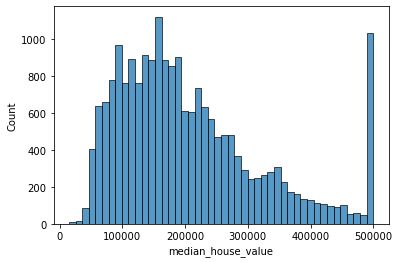

In [5]:
sns.histplot(df["median_house_value"]);

In [6]:
cols_to_keep = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]

df = df[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')].reset_index(drop=True)
df = df[cols_to_keep]
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
1,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
2,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
3,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
4,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


In [7]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [8]:
df['population'].median()

1195.0

In [14]:
n = len(df)

np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)

In [28]:
# Split (train, val, test sets)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

In [29]:
y_train = np.log1p(df_train['median_house_value'])
y_val = np.log1p(df_val['median_house_value'])
y_test = np.log1p(df_test['median_house_value'])

In [30]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [31]:
df_train.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,36.23,-119.14,22.0,2935.0,523.0,1927.0,530.0,2.5875
1,34.12,-117.79,16.0,2426.0,426.0,1319.0,446.0,4.8125
2,33.68,-117.97,26.0,3653.0,568.0,1930.0,585.0,5.7301
3,34.10,-118.03,32.0,2668.0,609.0,1512.0,541.0,2.9422
4,37.34,-121.87,39.0,2479.0,541.0,1990.0,506.0,2.4306


In [48]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [58]:
def prepare_X(df, fillna_method):
    _df = df.copy()

    if fillna_method == 'mean':
        _df['total_bedrooms'] = _df['total_bedrooms'].fillna(_df['total_bedrooms'].mean())
    else:
        _df['total_bedrooms'] = _df['total_bedrooms'].fillna(0)        

    X = _df.values
    
    return X

In [63]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [66]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [67]:
for fillna_method in ["0", "mean"]:

    print(f"Missing values imputation: {fillna_method}")

    X_train = prepare_X(df_train, fillna_method)
    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_train.dot(w)
    print(f"train: {round(rmse(y_train, y_pred), 2)}")

    X_val = prepare_X(df_val, fillna_method)
    y_pred = w_0 + X_val.dot(w)
    print(f"validation: {round(rmse(y_val, y_pred), 2)}")
    print()

Missing values imputation: 0
train: 0.34
validation: 0.34

Missing values imputation: mean
train: 0.34
validation: 0.34



In [76]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    print(f"Regularization: {r}")
    
    X_train = prepare_X(df_train, fillna_method="0")
    w_0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred = w_0 + X_train.dot(w)
    print(f"train: {round(rmse(y_train, y_pred), 2)}")
    
    X_val = prepare_X(df_val, fillna_method="0")
    y_pred = w_0 + X_val.dot(w)
    print(f"validation: {round(rmse(y_val, y_pred), 2)}")
    print()

Regularization: 0
train: 0.34
validation: 0.33

Regularization: 1e-06
train: 0.34
validation: 0.33

Regularization: 0.0001
train: 0.34
validation: 0.33

Regularization: 0.001
train: 0.34
validation: 0.33

Regularization: 0.01
train: 0.34
validation: 0.33

Regularization: 0.1
train: 0.34
validation: 0.33

Regularization: 1
train: 0.34
validation: 0.34

Regularization: 5
train: 0.35
validation: 0.34

Regularization: 10
train: 0.35
validation: 0.34



In [82]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

val_scores = []

for seed in seeds:

    print(f"Seed: {seed}")
    
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)

    # Split data into train/val/test sets
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test
    
    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

    y_train = np.log1p(df_train['median_house_value'])
    y_val = np.log1p(df_val['median_house_value'])
    y_test = np.log1p(df_test['median_house_value'])

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    X_train = prepare_X(df_train, fillna_method="0")
    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_train.dot(w)
    print(f"train: {round(rmse(y_train, y_pred), 2)}")
    
    X_val = prepare_X(df_val, fillna_method="0")
    y_pred = w_0 + X_val.dot(w)
    print(f"validation: {round(rmse(y_val, y_pred), 2)}")

    val_scores.append(rmse(y_val, y_pred))
    print()

val_sd = np.std(np.array(val_scores))
print(f"Validation SD: {round(val_sd, 3)}")


Seed: 0
train: 0.33
validation: 0.34

Seed: 1
train: 0.34
validation: 0.34

Seed: 2
train: 0.34
validation: 0.34

Seed: 3
train: 0.34
validation: 0.33

Seed: 4
train: 0.33
validation: 0.34

Seed: 5
train: 0.34
validation: 0.34

Seed: 6
train: 0.34
validation: 0.34

Seed: 7
train: 0.33
validation: 0.35

Seed: 8
train: 0.33
validation: 0.35

Seed: 9
train: 0.34
validation: 0.33

Validation SD: 0.005


In [97]:
seed = 9

np.random.seed(seed)
idx = np.arange(n)
np.random.shuffle(idx)

# Split data into train/val/test sets
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

y_train = np.log1p(df_train['median_house_value'])
y_val = np.log1p(df_val['median_house_value'])
y_test = np.log1p(df_test['median_house_value'])

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

df_train_full = pd.concat([df_train, df_val])
y_train_full = pd.concat([y_train, y_val])

X_train_full = prepare_X(df_train_full, fillna_method="0")
w_0, w = train_linear_regression_reg(X_train_full, y_train_full, r=0.001)
y_pred_full = w_0 + X_train_full.dot(w)

X_test = prepare_X(df_test, fillna_method="0")
y_pred = w_0 + X_test.dot(w)
print(f"Test RMSE: {round(rmse(y_test, y_pred), 2)}")

Test RMSE: 0.33
